<a href="https://colab.research.google.com/github/brighamfrandsen/mixtape/blob/main/Heterogeneous-Effects/Labs/python/ML_Heterogeneous_Effects%20w%20Oregon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Effects via Regression


Let's take up the example from the slides: what is the effect of going to a fancy college on later-life earnings? We'll use data on about 1,000 American men in the NLSY born 1980-1984 who finished college, and look at the effect of going to a private college ($D_i$) on earnings ($Y_i$) in 2015-2019 (when they were about 30-39 years old). We will be estimating an equation like this:

$$
Y_i = \delta D_i + X_i'\beta+\varepsilon_i,
$$

where $X_i$ is a vector of controls, conditional on which we are willing to assume $D_i$ is as good as randomly assigned.

What kinds of variables should we include in $X_i$?


In [ ]:
# Connect to github repo
!git clone https://github.com/Mixtape-Sessions/Heterogeneous-Effects.git
%cd Heterogeneous-Effects/Labs

In [ ]:
# import useful packages
import pandas as pd  # for loading and managing datasets
import statsmodels.api as sm  # for running regressions and getting standard errors

In [ ]:
# load NLSY data
nlsy = pd.read_csv(
    "data/nlsy97.csv"
)
nlsy

In [ ]:
# clean data (drop obs with missing values)
nlsy = nlsy.dropna().copy()
nlsy

Let's start with a simple (uncontrolled) regression.


In [ ]:
# Simple regression
rhs = sm.add_constant(
    nlsy["privatecollege"]
)  # you have to add the constant yourself with statsmodels!
model = sm.OLS(nlsy["annualearnings"], rhs)
results = model.fit(cov_type="HC3")  # heteroskedasticity-robust
print(results.summary())

How to interpret the coefficient on $privatecollege$? As a causal effect?


Now let's add controls for parent's education and cognitive ability as measured by ASVAB:


In [ ]:
# Regression with controls
rhs = sm.add_constant(nlsy[["privatecollege", "dadcollege", "momcollege", "asvab"]])
model = sm.OLS(nlsy["annualearnings"], rhs)
results = model.fit(cov_type="HC3")
print(results.summary())

How did the inclusion of controls change the estimate? Why?


Back to the whiteboard for prediction!


# Prediction Primer


Let's use decision trees to predict which participants of the National JTPA Study were likely to find a job. We will use prior earnings, education, sex, race, and marital status as our prediction features.


In [ ]:
data = pd.read_csv(
    "data/jtpahet.csv"
)
data

Import some utilities:


In [ ]:
%cd python
import plot_helpers
import tools
import plot_2d_separator
import plot_interactive_tree
%cd ..

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.tree import plot_tree

We'll first grow a tree using just two features (education and prior earnings) so we can visualize it easily. Let's visualize the feature space: triangles are individuals who found a job, circles are those who didn't.


In [ ]:
plot_helpers.discrete_scatter(
    data.loc[:, "educ"].values,
    data.loc[:, "priorearn"].values,
    data.loc[:, "foundjob"].values
)
plt.show()

In [ ]:
tree = DecisionTreeClassifier(max_depth=3,class_weight="balanced").fit(
    data.loc[:, ["educ", "priorearn"]].values, data.loc[:, "foundjob"].values
)
fig1, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_interactive_tree.plot_tree_partition(
    data.loc[:, ["educ", "priorearn"]].values,
    data.loc[:, "foundjob"].values,
    tree,
    ax=ax,
)


In [ ]:
plot_tree(
    tree,
    feature_names=["education", "Prior earnings"],
    class_names=["No job", "Found job"],
    impurity=False,
    filled=True, fontsize=6
)
plt.show()

On your own: grow another tree, but without setting `max_depth`, and plot the decision boundary.

How well do you think this un-pruned tree fits the training data compared to the simpler tree above? How well do you think the un-pruned tree would predict an out-of-sample observation?

Back to the whiteboard!

Now let's do a random forest:


In [ ]:
forest = RandomForestClassifier(n_estimators=5, random_state=2,class_weight="balanced").fit(
    data.loc[:, ["educ", "priorearn"]].values, data.loc[:, "foundjob"].values
)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_interactive_tree.plot_tree_partition(
        data.loc[:, ["educ", "priorearn"]].values,
        data.loc[:, "foundjob"].values,
        tree,
        ax=ax,
    )

plot_2d_separator.plot_2d_separator(
    forest,
    data.loc[:, ["educ", "priorearn"]].values,
    fill=True,
    ax=axes[-1, -1],
    alpha=0.4,
)
axes[-1, -1].set_title("Random Forest")
plot_helpers.discrete_scatter(
    data.loc[:, "educ"].values,
    data.loc[:, "priorearn"].values,
    data.loc[:, "foundjob"].values,
)
plt.show()

We only used two prediction features (prior earnings and education) for visualization. To get the best predictions, we should use all of our features. And to evaluate the quality of the prediction, we should hold out a test set.


In [ ]:
# Define a matrix of features:
X = data[["age", "priorearn", "educ", "female", "nonwhite", "married"]]
# hold out a test test:
X_train, X_test, y_train, y_test = train_test_split(
    X, data["foundjob"], random_state=42
)

Try on your own: grow a forest with 500 trees using the training set, and evaluate the prediction accuracy on the test set. Hint: you can evaluate the prediction accuracy by doing `forest.score(X_test,y_test)`.


##Cheat


In [ ]:
forest = RandomForestClassifier(n_estimators=500, random_state=2).fit(X_train, y_train)
forest.score(X_test, y_test)

##

So much for predicting _outcomes_. We want to predict causal effects. Back to the whiteboard!


# Traditional regression-based heterogeneous treatment effects

Back to NLSY example. Let's see how the effect of attending a private college varies by whether a parent is college educated. Let's define a variable, $parentcollege$, equal to one if either parent attended college, and zero otherwise:

In [ ]:
nlsy['parentcollege'] = ((nlsy['dadcollege'] == 1) | (nlsy['momcollege'] == 1)).astype(int) # astype(int) makes the values to be 0/1 instead of False/True

Let's estimate the effect of private college among those with no parent who went to college:

In [ ]:
# restrict to obsevations where parentcollege==0. No longer need to control separately for dadcollege, momcollege
rhs = sm.add_constant(nlsy.loc[nlsy['parentcollege']==0,["privatecollege", "asvab"]])
model = sm.OLS(nlsy.loc[nlsy['parentcollege']==0,["annualearnings"]], rhs)
results = model.fit(cov_type="HC3")
print(results.summary())

How does the effect compare to the effect in the full sample?

On your own: run the regression among those where at least one parent went to college.

## Cheat

In [ ]:
rhs = sm.add_constant(nlsy.loc[nlsy['parentcollege']==1,["privatecollege", "asvab"]])
model = sm.OLS(nlsy.loc[nlsy['parentcollege']==1,["annualearnings"]], rhs)
results = model.fit(cov_type="HC3")
print(results.summary())

##

How does the effect compare to that among those where neither parent went to college?

On your own: run as a single regression where you include interactions between $privatecollege$ and $parentcollege$, and between $asvab$ and $parentcollege$:

## Cheat

In [ ]:
nlsy['privateXparent']=nlsy['privatecollege']*nlsy['parentcollege']
nlsy['asvabXparent']=nlsy['asvab']*nlsy['parentcollege']
rhs = sm.add_constant(nlsy.loc[:,["privatecollege","privateXparent", "asvabXparent","parentcollege","asvab"]])
model = sm.OLS(nlsy.loc[:,["annualearnings"]], rhs)
results = model.fit(cov_type="HC3")
print(results.summary())

##

How do the single-regression results compare to the separate regressions?

Back to the whiteboard!

# Using Machine Learning to Predict Heterogeneous Treatment Effects


## Key Challenge: Algorithms tailored for predicting outcomes can do poorly when predicting treatment effects


### Factors that strongly predict outcomes may not strongly predict treatment effects


$Y_i$: spending on a Lexus

$D_i$: seeing an online ad for a Lexus

$\ln Y_i=\beta_0+\beta_1 age_i +\beta_2 male_i + \beta_3 D_i+\beta_4 D_i \times male_i +\varepsilon_i$

How do outcomes vary by age? (A lot if $\beta_1$ is big)

How do treatment effects vary by age? (not at all!)

What do treatment effects vary by? (gender!)


Let's simulate some data to show what happens when we try to use algorithm tailored to predicting outcomes for predicting treatment effects.


In [ ]:
import numpy as np
from sklearn import tree

In [ ]:
# define parameters
n = 1000  # sample size
p = 0.5  # probability of seeing the ad
beta0 = 0
beta1 = 0.2  # effect of age
beta2 = (
    -0.025
)  # difference in average spending between males and females who don't see the ad ()
beta3 = 0  # effect of treatment among females
beta4 = 0.05  # differential effect of treatment among males compared to females
sigeps = 0.02  # residual variance of outcome

# generate some fake data
age = np.random.randint(low=18, high=61, size=(n, 1))
male = np.random.randint(low=0, high=2, size=(n, 1))
d = np.random.rand(n, 1) > (1 - p)
epsilon = sigeps * np.random.randn(n, 1)
lny = beta0 + beta1 * age + beta2 * male + beta3 * d + beta4 * d * male + epsilon

# assemble as dataframe
fakedata = pd.DataFrame(
    np.concatenate((lny, d, age, male), axis=1), columns=["lny", "d", "age", "male"]
)
fakedata.feature_names = ["age", "male"]
x0 = fakedata.loc[d == 0, ["age", "male"]]
x1 = fakedata.loc[d == 1, ["age", "male"]]
y0 = fakedata.loc[d == 0, ["lny"]]
y1 = fakedata.loc[d == 1, ["lny"]]

Try on your own: fit two trees (call them `tree0` and `tree1`), each with `max_depth=2` to predict the outcome separately in the untreated ($D_i=0$) and treated ($D_i=1$) samples, using `x0` and `x1`, respectively.


In [ ]:
# fit trees

In [ ]:
# display trees

###Cheat


In [ ]:
# fit trees
tree1 = DecisionTreeRegressor(max_depth=2).fit(x1, y1)
tree0 = DecisionTreeRegressor(max_depth=2).fit(x0, y0)

In [ ]:
# display trees
print("Treated tree:")
plot_tree(tree1, filled=True, feature_names=fakedata.feature_names)
plt.show()

In [ ]:
print("Untreated tree:")
plot_tree(tree0, filled=True, feature_names=fakedata.feature_names)
plt.show()

###

Which variable(s) did the trees key in on? Why? Would these trees be useful for predicting treatment effects? Why or why not?

How do we fix the problem?


### Non-Honest trees can exaggerate differences between groups

In [ ]:
#generate a bunch of predictors:
x1=np.random.randint(low=0,high=2,size=(n,1))
x2=np.random.randint(low=0,high=2,size=(n,1))
x3=np.random.randint(low=0,high=2,size=(n,1))
x4=np.random.randint(low=0,high=2,size=(n,1))
x5=np.random.randint(low=0,high=2,size=(n,1))
x6=np.random.randint(low=0,high=2,size=(n,1))
x7=np.random.randint(low=0,high=2,size=(n,1))
x8=np.random.randint(low=0,high=2,size=(n,1))
x9=np.random.randint(low=0,high=2,size=(n,1))
x10=np.random.randint(low=0,high=2,size=(n,1))

# Each of these predictors affects the outcome with coefficient = 1:
y=x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+epsilon

# Let's put these features in a matrix:
predictors=np.concatenate((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10),axis=1)
predictor_names=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']

On your own: grow and display a tree (max_depth=2) to predict y on the basis of these features

### Cheat

In [ ]:
dishonest=DecisionTreeRegressor(max_depth=2)
dishonest.fit(predictors,y)
d=tree.plot_tree(dishonest,filled=True,feature_names=predictor_names)

### Discussion:

According to our "model" for y, what should be the difference between outcomes in neighboring leaves from the same node? (one!) What are the observed differences in the tree? (greater than one!)

Solution: Honest trees, or double-sample trees, use a subset of the training set to grow the tree, and another subset to estimate means in each leaf

## Honest Trees

In [ ]:
# Randomly select observations to be the training set:
train=np.random.randint(low=0,high=2,size=n)==1

On your own: grow a tree using the training set (max_depth=2), and display it.

### Cheat

In [ ]:
# Grow tree on training set:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(predictors[train,:],y[train])
d=tree.plot_tree(dt,filled=True,feature_names=predictor_names)

###

Now use the estimation set to calculate the means in each leaf:

In [ ]:
leaves=dt.apply(predictors[~train])
yest=y[~train]
honest=dt
n_nodes = honest.tree_.node_count
for ii in range(n_nodes):
  if honest.tree_.children_left[ii]==-1: # means that the current node is a leaf
    estii=yest[leaves==ii]
    honest.tree_.value[ii]=estii.mean() # replace the leaf's value with the estimation set's mean

d=tree.plot_tree(honest,filled=True,feature_names=predictor_names)

The leaf means are not nearly as extreme as in the "dishonest" tree that uses the training observations to construct the predictions

## Random Causal Forest: Simulated Example


In [ ]:
# Install econml
%pip install econml #&> /dev/null

In [ ]:
from econml.dml import CausalForestDML as CausalForest

In [ ]:
# NOTE: If you are getting `np.int` error, do the following:
# pip install --force-reinstall numpy==1.23.5
# There is a fix for the new numpy version, but it's not released yet:
# https://github.com/py-why/EconML/commit/0be16255f10853fc9fe0774cb5649e051dc55dff

# Instantiate the Causal Forest
estimator = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het")

# Grow the forest
estimator.fit(
    fakedata["lny"], fakedata["d"], X=fakedata[["age", "male"]]  # outcome  # treatment
)  # prediction features

# Predict effects for each observation based on its characteristics:
effects = estimator.effect(fakedata[["age", "male"]])

Let's see how well it did at estimating effects among men and women:


In [ ]:
malefx = effects[fakedata["male"].values == 1]
malefx.mean()

In [ ]:
femalefx = effects[fakedata["male"].values == 0]
femalefx.mean()

How did our causal forest do at getting effects right for men and women? Let's see how it does on the age profile:


In [ ]:
fig = plt.figure()
ax = plt.axes()
maleage = fakedata["age"].iloc[fakedata["male"].values == 1]
femaleage = fakedata["age"].iloc[fakedata["male"].values == 0]

ax.scatter(maleage, malefx, label="males")
ax.scatter(femaleage, femalefx, label="females")
ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("age")
plt.ylabel("treatment effect")

A little noisy on the age profile (which should be flat) but does get the difference between men and women!


## Random Causal Forest: Predict the effects of job training


We are ready to apply machine learning to predict causal effects in a real-life setting: how do the effects of job training vary by an individual's characteristics? We will use data from the National Job Training Partnership study, a large-scale randomized evaluation of a publicly subsidized job training program for disadvantaged youth and young adults. Why would we care how the effects of a subsidized job training program vary by a person's characteristics?


We will use the JTPA evaluation dataset, which contains observations on about 14,000 individuals, some of whom were randomized to participate in job training ($z_i = 1$) and others who were not ($z_i = 0$).

To do on your own:

- load the dataset from the `data/jtpahet.csv`
- define the outcome vector (call it `y`) to be the column labeled `foundjob`
- define the randomized assignment indicator (call it `z`) to be the column labeled `z`
- define the feature vector (call it `x`) to be all columns except `foundjob`, `z`, and `enroll`.


In [ ]:
# load the data

# define the variables

### Cheat


In [ ]:
data = pd.read_csv(
    "data/jtpahet.csv"
)
data

In [ ]:
y = data["foundjob"]
z = data["z"]
x = data.drop(["foundjob", "z", "enroll"], axis=1)
x

### Regression to get average effect


On your own: run a linear regression of the outcome on the random assignment indicator, `z`. Since this was a randomized experiment, we don't need controls!


### Cheat:


In [ ]:
rhs = sm.add_constant(
    data["z"]
)  # you have to add the constant yourself with statsmodels!
model = sm.OLS(data["foundjob"], rhs)
results = model.fit(cov_type="HC3")  # heteroskedasticity-robust
print(results.summary())

### Set up random forest


So far, so good? Now create a random causal forest object, and fit it with outcome `y`, treatment variable `z`, and feature matrix `x`.


In [ ]:
# On your own: create and fit random causal forest object

### Cheat


In [ ]:
rcf = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het").fit(
    y, z, X=x
)

### Explore effects


Let's see what kind of heterogeneous effects our random causal forest predicted


In [ ]:
# calculate the predicted effects:
insamplefx = rcf.effect(x)
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()
ax.hist(insamplefx, bins=30, density=True)
plt.axvline(rcf.ate_, color="k", linestyle="dashed", linewidth=1)
plt.suptitle("Estimated Treatment effects")
plt.title("ATE: {:.3g}".format(rcf.ate_[0]))
plt.show()

Let's visualize how these effects vary by prior earnings and education by making a heatmap


In [ ]:
import itertools

In [ ]:
# create a grid of values for education and prior earnings:
educgrid = np.arange(data["educ"].values.min(), data["educ"].values.max() + 1)
earngrid = np.arange(
    data["priorearn"].values.min(), data["priorearn"].values.max(), 5000
)
grid = pd.DataFrame(
    itertools.product(educgrid, earngrid), columns=["educ", "priorearn"]
)

We'll first visualize the effects among married, nonwhite females of average age:


In [ ]:
grid["age"] = data["age"].values.mean()  # set age to the average
grid["female"] = 1  # set female = 1
grid["nonwhite"] = 1  # set nonwhite = 1
grid["married"] = 1  # set married = 1
# need to re-order the columns to match x:
grid=grid[x.columns]


To do on your own: calculate the predicted effects for each "observation" in the grid:


In [ ]:
# gridfx = # uncomment and fill in on your own!

### Cheat


In [ ]:
gridfx = rcf.effect(grid)

### Visualize effects with a heatmap:


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = plt.subplot()
main = ax.scatter(
    grid["educ"], grid["priorearn"], c=gridfx, cmap="plasma", marker="s", s=300
)
plt.suptitle("Estimated Treatment effects")
plt.title("Nonwhite married females")
plt.xlabel("years of education")
plt.ylabel("prior earnings")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(main, cax=cax)
plt.show()

To do on your own: make similar visualizations for males, singles, whites, different ages, etc.


## Self-directed Project

In the data folder is a file called `oregon.csv` with data on about 24,000 individuals from the Oregon Health Insurance Experiment, which allocated by lottery offers to enroll in Oregon's Medicaid program. The file `oregon var descriptions.txt` contains descriptions of the variables in the dataset. Load this dataset, or another dataset of your choosing, and apply the tools we have learned to explore heterogeneous treatment effects. Hints: like all real-world datasets, there are observations with missing values for some of the variables. For the Oregon data, the randomized treatment variable (`offeredmedicaid`) is random conditional on survey wave and household size, which are indicated by the set of variables that start with `ddd...`. Analyses should include those variables as controls. it may be interesting to estimate heterogeneity in the effects of the random offer (`offeredmedicaid`) on actual enrollment (`enrolledmedicaid`), as well as the effects of the random offer on health and utilization outcomes.

In [55]:
# Load data
oregon = pd.read_csv("/content/oregon.csv")

oregon


,offeredmedicaid,female_list,doc_num_mod,cost_borrow,race_hisp,race_black,edu,enrolledmedicaid,ddddraw_sur_2,ddddraw_sur_3,...,ddddraXnum_3_2,ddddraXnum_3_3,ddddraXnum_4_2,ddddraXnum_5_2,ddddraXnum_6_2,ddddraXnum_7_2,fpl_categ,notbaddays_tot,notbaddays_ment,age
0,1,0.0,0.0,1.0,0.0,0.0,2.0,0,0,0,...,0,0,0,0,0,0,1.0,10.0,0.0,30
1,1,1.0,0.0,0.0,0.0,0.0,2.0,1,0,0,...,0,0,0,0,0,0,2.0,24.0,18.0,24
2,1,1.0,0.0,0.0,1.0,0.0,2.0,0,0,0,...,0,0,0,0,0,0,4.0,0.0,0.0,39
3,1,0.0,1.0,0.0,0.0,0.0,4.0,0,0,1,...,0,0,0,0,0,0,1.0,28.0,26.0,62
4,0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,1,...,1,0,0,0,0,0,1.0,30.0,30.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23736,0,0.0,4.0,0.0,0.0,1.0,NaN,0,0,0,...,0,0,0,0,0,0,1.0,15.0,20.0,53
23737,0,1.0,2.0,0.0,0.0,0.0,4.0,0,0,0,...,0,0,0,0,0,0,5.0,30.0,29.0,53
23738,1,0.0,2.0,0.0,0.0,0.0,1.0,0,0,1,...,1,0,0,0,0,0,4.0,10.0,0.0,45
23739,0,1.0,5.0,1.0,NaN,0.0,NaN,0,0,0,...,0,0,0,0,0,0,NaN,0.0,0.0,61


In [56]:
# Clean data
oregon=oregon.dropna().copy()
oregon.shape


(18193, 28)

In [140]:
# Estimate overall average effects
# define controls

X=oregon.filter(like='ddd').columns.tolist()
rhs=sm.add_constant(oregon[['offeredmedicaid']+X])
outcomes=["enrolledmedicaid","cost_borrow","doc_num_mod","notbaddays_tot","notbaddays_ment"]
for y in outcomes:
  model = sm.OLS(oregon[y], rhs)
  results = model.fit(cov_type="HC3")
  print(results.summary())



                            OLS Regression Results                            
Dep. Variable:       enrolledmedicaid   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     134.6
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        01:27:43   Log-Likelihood:                -10063.
No. Observations:               18193   AIC:                         2.016e+04
Df Residuals:                   18175   BIC:                         2.030e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1918      0.013     

In [141]:
# Explore heterogeneity
# define matrix of characteristics
x = oregon.drop(columns=['offeredmedicaid']+outcomes)
rcf = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het").fit(
    oregon['enrolledmedicaid'], oregon['offeredmedicaid'], X=x
)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

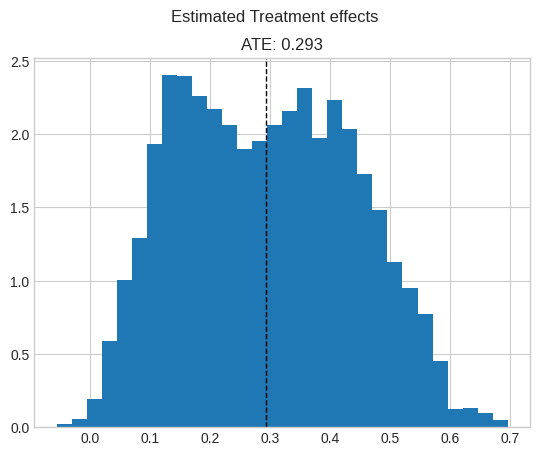

In [142]:
insamplefx = rcf.effect(x)
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()
ax.hist(insamplefx, bins=30, density=True)
plt.axvline(rcf.ate_, color="k", linestyle="dashed", linewidth=1)
plt.suptitle("Estimated Treatment effects")
plt.title("ATE: {:.3g}".format(rcf.ate_[0]))
plt.show()

In [160]:
# create a grid of values for education and prior earnings:
educgrid = np.arange(oregon["edu"].values.min(), oregon["edu"].values.max() + 1)
agegrid = np.arange(
    oregon["age"].values.min(), oregon["age"].values.max()+1
)
grid = pd.DataFrame(
    itertools.product(educgrid, agegrid), columns=["edu", "age"]
)

In [161]:
otherxs = [xvar for xvar in x.columns if xvar not in ['edu','age']]
for xvar in otherxs:
  grid[xvar] = oregon[xvar].values.mean()

# need to re-order the columns to match x:
grid=grid[x.columns]

In [162]:
gridfx = rcf.effect(grid)

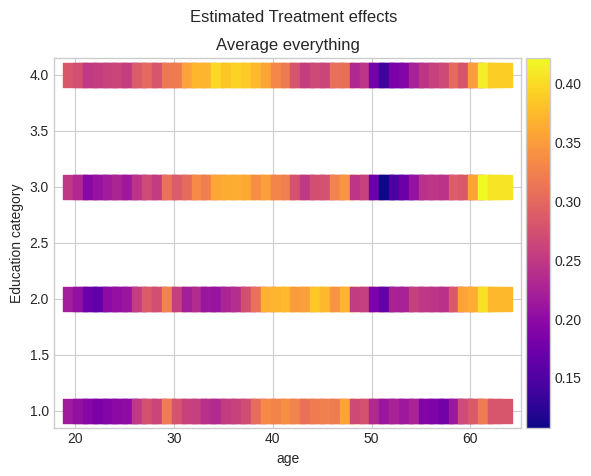

In [164]:
fig = plt.figure()
ax = plt.subplot()
main = ax.scatter(
     grid["age"],grid["edu"], c=gridfx, cmap="plasma", marker="s", s=300
)
plt.suptitle("Estimated Treatment effects")
plt.title("Average everything")
plt.xlabel("age")
plt.ylabel("Education category")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(main, cax=cax)
plt.show()